In [1]:
import pandas as pd
import math as m
from scipy import stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import  metrics
from itertools import product
%pylab inline

/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/home/vladimir/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from keras.layers import LSTM, SpatialDropout1D
import keras

/home/vladimir/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data = pd.read_csv("cleaned_unemployment.csv", index_col=['Unnamed: 0'])
GDP = pd.read_csv("cleaned_GDP.csv", index_col=['Unnamed: 0'])
data = pd.concat([data , GDP], axis = 1)
np.random.seed(42)

In [4]:
def time_series_to_DataFrame(data, lags, target):
    lags = list(map(lambda x: x+1, lags))
    #Готовим название колонок
    columns = []
    for i in range(len(data.columns)):
        #print (i , lags[i])
        for j in range(1, lags[i]):
            #print ('i = ', i,'j = ',j)
            #print (columns)
            columns.append(data.columns[i] + '_lag_' + str(j))
    columns.append(target)
    #готовим target
    target = pd.DataFrame(data[target].values[max(lags)-1:])
    #готовим индексы
    index = data.index
    
    
    data = data.values
    
    new_data = []
    for i in range(max(lags)-1,len(data)):
        res = []
        for lag in range(len(lags)):
            for j in range(1,lags[lag]):
                res.append(data[i-j][lag])
        new_data.append(res)
    
    
    new_data = pd.DataFrame(new_data)
    new_data = pd.concat([new_data, target], axis = 1)
    new_data.columns = columns
    new_data.index = index[max(lags)-1:]
    return new_data 

In [5]:
#лаги
lags = [5,3]
lag_data = time_series_to_DataFrame(data, lags, 'unemployment_cyclicity')

x_train = lag_data[lag_data.columns[:-1]].iloc[:-20]
x_val = lag_data[lag_data.columns[:-1]].iloc[-20:-12]
x_test = lag_data[lag_data.columns[:-1]].iloc[-12:]

y_train = lag_data[lag_data.columns[-1]].iloc[:-20]
y_val = lag_data[lag_data.columns[-1]].iloc[-20:-12]
y_test = lag_data[lag_data.columns[-1]].iloc[-12:]

In [6]:
x_test.head()

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110
2014.50,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.017511,0.016362
2014.75,-0.058753,-0.057857,-0.048167,-0.039545,-0.039611,0.014936,0.017804,0.017511
2015.00,-0.039524,-0.058753,-0.057857,-0.048167,-0.039545,0.007688,0.014936,0.017804
2015.25,-0.011284,-0.039524,-0.058753,-0.057857,-0.048167,-0.000313,0.007688,0.014936


In [7]:
def load_weights(model,name_of_catalog, neurons_1, neurons_2):
    for i in range(len(neurons_1)):
        for j in range(len(neurons_2)):
            from keras.models import model_from_json
            #print("Загружаю сеть из файлов")
            # Загружаем сохраненные веса в модель
            print (i, j)
            model[i][j].load_weights(name_of_catalog+"/weights_"+str(neurons_1[i])+'_'+str(neurons_2[j])+".hdf5")
    print("Загрузка сети завершена")
    return model

In [8]:
%%time
np.random.seed(42)
neurons_1 = range(5, 10)
neurons_2 = range(5, 10)
epochs = 100

model = []
history = []
for i in range(len(neurons_1)):
    model.append([])
    history.append([])
    for j in range(len(neurons_2)):
        print (neurons_1[i], neurons_2[j])
        model[i].append(Sequential())
        filepath="model/weights_"+str(neurons_1[i])+'_'+str(neurons_2[j])+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        model[i][j].add(Dense(neurons_1[i], activation='relu', input_shape=(x_train.shape[1],), ))
        model[i][j].add(Dropout(0.05))
        model[i][j].add(Dense(neurons_2[j], activation='relu', ))
        model[i][j].add(Dense(1))
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model[i][j].compile(optimizer=adam, loss='mae', metrics=['mae'])
        #history[i].append(model[i][j].fit(x_train, y_train, epochs=epochs, batch_size=1,
        #                           verbose=2, validation_data=(x_val, y_val),callbacks = [checkpoint] ))
        

5 5
5 6
5 7
5 8
5 9
6 5
6 6
6 7
6 8
6 9
7 5
7 6
7 7
7 8
7 9
8 5
8 6
8 7
8 8
8 9
9 5
9 6
9 7
9 8
9 9
CPU times: user 1.41 s, sys: 20 ms, total: 1.43 s
Wall time: 1.64 s


In [9]:
load_model = load_weights(model,'model', neurons_1, neurons_2)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
Загрузка сети завершена


In [10]:
def find_best_model(history,model, neurons_1 ,neurons_2, y_test, x_test ):
    
    if history != None:
        ## Список качества
        list_of_quality = []
        for i in range(len(history)):
            list_of_quality.append([])
            for j in range(len(history[0])):
                list_of_quality[i].append(history[i][j].history['val_mean_absolute_error'][-1])
    
        min_ = list_of_quality[0][0]
        i_min = -1
        j_min = -1
        for i in range(len(list_of_quality)):
            for j in range(len(list_of_quality[0])):
                if list_of_quality[i][j] <= min_:
                    min_ = list_of_quality[i][j]
                    j_min = j
                    i_min = i
                
        # История ошибок
        plt.figure(figsize(10,5))
        plt.plot(history[i_min][j_min].history['mean_absolute_error'])
        plt.plot(history[i_min][j_min].history['val_mean_absolute_error'])
        plt.title("error " + str(neurons_1[i_min]) + " and " +str(neurons_2[j_min]))
    else:
        MAE = metrics.mean_absolute_error(y_test.values,model[0][0].predict(x_test))
        i_min = j_min = 0
        for i in range(len(model)):
            for j in range(len(model[0])):
                current_MAE = metrics.mean_absolute_error(y_test.values,model[i][j].predict(x_test))
                if current_MAE <= MAE:
                    MAE = current_MAE
                    i_min = i
                    j_min = j
        
    # предесказание
    pred = model[i_min][j_min].predict(x_test)
    plt.figure(figsize(10,5))
    plt.plot(y_test.index, pred, color = 'r')
    plt.plot(y_test.index, y_test.values)
    #plt.title("prediction " + str(neurons_1[i_min]) + " and " +str(neurons_2[j_min]))
    
    print ('Средняя ошибка = ', metrics.mean_absolute_error(y_test.values,pred))

    return i_min, j_min

Средняя ошибка =  0.007829626882896937


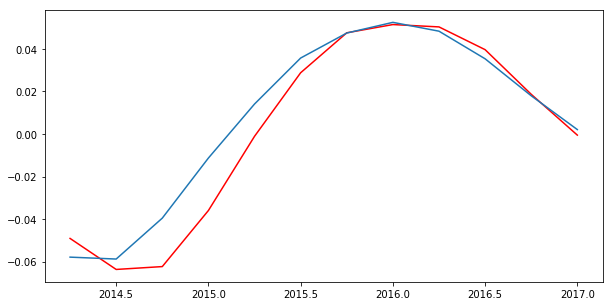

In [11]:
i_best_st, j_best_st = find_best_model(None,load_model, neurons_1 ,neurons_2, y_test, x_test )

Средняя ошибка =  0.008937878351217565


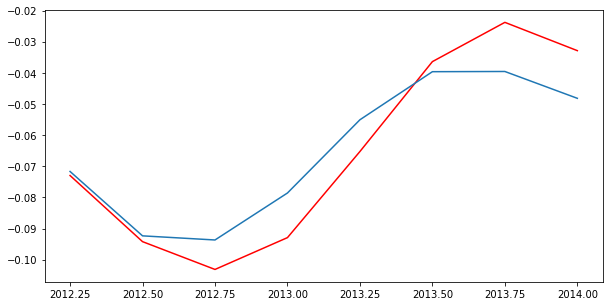

In [12]:
i_best, j_best = find_best_model(None,load_model, neurons_1 ,neurons_2, y_val, x_val )

0.008838154707972
0.9083316930286479


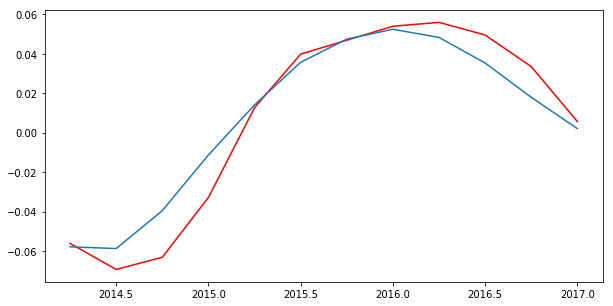

In [13]:
pred_test = load_model[i_best][j_best].predict(x_test)
pred_val = load_model[i_best][j_best].predict(x_val)
pred_train = load_model[i_best][j_best].predict(x_train)


pred_val = list(pred_val.reshape((1, len(pred_val)))[0])
pred_train = list(pred_train.reshape((1, len(pred_train)))[0])
pred_test = list(pred_test.reshape((1, len(pred_test)))[0])


plt.figure(figsize(10,5))
plt.plot(y_test.index, pred_test, color = 'r')
plt.plot(y_test.index, y_test.values)
print (metrics.mean_absolute_error(y_test.values,pred_test))
print (metrics.r2_score(y_test.values,pred_test))

In [14]:
x_test_2 = x_test[:]

In [15]:
x_test_2.head()

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110
2014.50,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.017511,0.016362
2014.75,-0.058753,-0.057857,-0.048167,-0.039545,-0.039611,0.014936,0.017804,0.017511
2015.00,-0.039524,-0.058753,-0.057857,-0.048167,-0.039545,0.007688,0.014936,0.017804
2015.25,-0.011284,-0.039524,-0.058753,-0.057857,-0.048167,-0.000313,0.007688,0.014936


In [16]:
x_test_2.iloc[1]

unemployment_cyclicity_lag_1   -0.057857
unemployment_cyclicity_lag_2   -0.048167
unemployment_cyclicity_lag_3   -0.039545
unemployment_cyclicity_lag_4   -0.039611
unemployment_cyclicity_lag_5   -0.055057
GDP_cyclicity_lag_1             0.017804
GDP_cyclicity_lag_2             0.017511
GDP_cyclicity_lag_3             0.016362
Name: 2014.5, dtype: float64

In [17]:
for i in range(10,100):
    x_test_2.loc[12+i] = list(x_test_2.iloc[1])[:6] + [0.010511 + i * 0.003] + list(x_test_2.iloc[1])[7:]

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
x_test_3 = x_test_2.iloc[11:]
x_test_3.head()

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2017.0,0.017972,0.035348,0.048324,0.052475,0.047457,-0.008231,-0.012339,-0.013727
22.0,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.040511,0.016362
23.0,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.043511,0.016362
24.0,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.046511,0.016362
25.0,-0.057857,-0.048167,-0.039545,-0.039611,-0.055057,0.017804,0.049511,0.016362


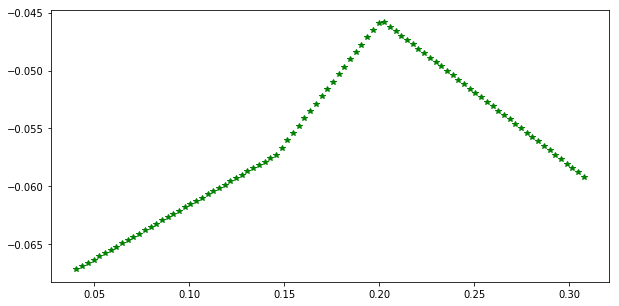

In [19]:
plt.plot(x_test_3.GDP_cyclicity_lag_2.values[1:], load_model[i_best][j_best].predict(x_test_3)[1:],'g*' )

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


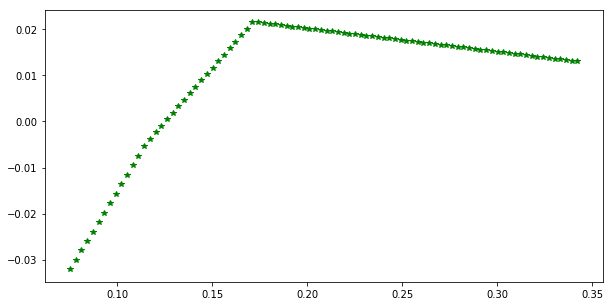

In [20]:
x_test_2 = x_test[:]
for i in range(90):
    x_test_2.loc[12+i] = list(x_test_2.iloc[1])[:7] + [0.07511 + i * 0.003] + list(x_test_2.iloc[1])[8:]
x_test_3 = x_test_2.iloc[11:]
plt.plot(x_test_3.GDP_cyclicity_lag_3.values[1:], load_model[i_best][j_best].predict(x_test_3)[1:],'g*' )

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


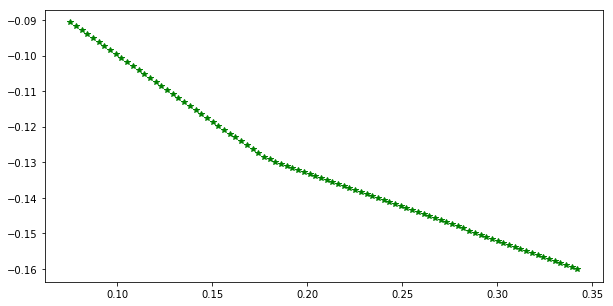

In [21]:
x_test_2 = x_test[:]
for i in range(90):
    x_test_2.loc[12+i] = list(x_test_2.iloc[1])[:5] + [0.07511 + i * 0.003] + list(x_test_2.iloc[1])[6:]
x_test_3 = x_test_2.iloc[11:]
plt.plot(x_test_3.GDP_cyclicity_lag_1.values[1:], load_model[i_best][j_best].predict(x_test_3)[1:],'g*' )

In [22]:
load_model[i_best][j_best].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 6)                 54        
_________________________________________________________________
dropout_9 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 119
Trainable params: 119
Non-trainable params: 0
_________________________________________________________________


# линеная модель для ВВП

In [23]:
from sklearn.linear_model import LinearRegression
LinearRegression_model = LinearRegression()
GDP_y = x_train['GDP_cyclicity_lag_1']
GDP_x = x_train[['GDP_cyclicity_lag_2','GDP_cyclicity_lag_3']]
LinearRegression_model.fit(GDP_x, GDP_y.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Положительный шок ВВП

In [24]:
x_test_2 = x_test.iloc[:1]

In [25]:
x_test_2

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.01611


In [26]:
#Положительный импульс
x_test_2.loc[2014.50] = list(x_test_2.loc[2014.25])[:5] + [0.017511 + 1] + list(x_test_2.loc[2014.25])[6:]

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
x_test_2

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.01611
2014.50,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,1.017511,0.016362,0.01611


In [28]:
pred = [x_test.iloc[:1].values[0][0]]
pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])

In [29]:
pred

[-0.048167102716005335, -0.3210207]

In [30]:
for i in range(12):
    #Создание новой строчки
    new_line = []
    new_line.append(pred[-1])
    new_line = new_line + list(x_test_2.iloc[-1])[0:4]  +[LinearRegression_model.predict(np.array(list(x_test_2.iloc[-1])[5:7]).reshape(1, -1))[0]] +list(x_test_2.iloc[-1])[5:7]
    #добавление новой строчки
    x_test_2.loc[2014.75+0.25*i] = new_line
    pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [31]:
x_test_2

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110
2014.50,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,1.017511,0.016362,0.016110
2014.75,-0.321021,-0.048167,-0.039545,-0.039611,-0.055057,1.768449,1.017511,0.016362
2015.00,-0.592592,-0.321021,-0.048167,-0.039545,-0.039611,2.191856,1.768449,1.017511
2015.25,-0.575947,-0.592592,-0.321021,-0.048167,-0.039545,2.264347,2.191856,1.768449
2015.50,-0.348065,-0.575947,-0.592592,-0.321021,-0.048167,2.013879,2.264347,2.191856
2015.75,-0.066327,-0.348065,-0.575947,-0.592592,-0.321021,1.510292,2.013879,2.264347
2016.00,0.085523,-0.066327,-0.348065,-0.575947,-0.592592,0.851065,1.510292,2.013879
2016.25,0.081520,0.085523,-0.066327,-0.348065,-0.575947,0.144754,0.851065,1.510292
2016.50,0.166010,0.081520,0.085523,-0.066327,-0.348065,-0.505303,0.144754,0.851065


In [32]:
pred

[-0.048167102716005335,
 -0.3210207,
 -0.5925917,
 -0.5759471,
 -0.34806472,
 -0.06632711,
 0.085522816,
 0.08151984,
 0.16600986,
 0.26070604,
 0.23368993,
 0.16906708,
 0.03504559,
 -0.21967772]

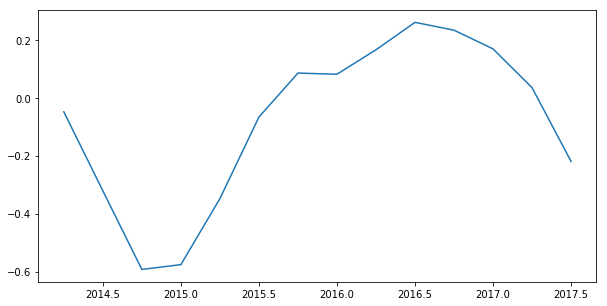

In [33]:
plt.plot(x_test_2.index.values, pred)

# Отрицательный шок

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


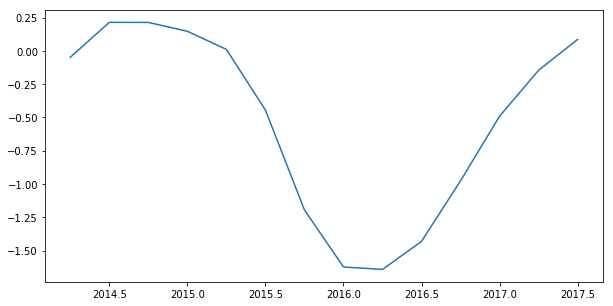

In [34]:
x_test_2 = x_test.iloc[:1]
x_test_2.loc[2014.50] = list(x_test_2.loc[2014.25])[:5] + [0.017511 - 1] + list(x_test_2.loc[2014.25])[6:]
pred = [x_test.iloc[:1].values[0][0]]
pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
for i in range(12):
    #Создание новой строчки
    new_line = []
    new_line.append(pred[-1])
    new_line = new_line + list(x_test_2.iloc[-1])[0:4]  +[LinearRegression_model.predict(np.array(list(x_test_2.iloc[-1])[5:7]).reshape(1, -1))[0]] +list(x_test_2.iloc[-1])[5:7]
    #добавление новой строчки
    x_test_2.loc[2014.75+0.25*i] = new_line
    pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
plt.plot(x_test_2.index.values, pred)

In [35]:
x_test_2

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110
2014.50,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,-0.982489,0.016362,0.016110
2014.75,0.213846,-0.048167,-0.039545,-0.039611,-0.055057,-1.736598,-0.982489,0.016362
2015.00,0.213374,0.213846,-0.048167,-0.039545,-0.039611,-2.167611,-1.736598,-0.982489
2015.25,0.146719,0.213374,0.213846,-0.048167,-0.039545,-2.250604,-2.167611,-1.736598
2015.50,0.010803,0.146719,0.213374,0.213846,-0.048167,-2.011760,-2.250604,-2.167611
2015.75,-0.444898,0.010803,0.146719,0.213374,0.213846,-1.519182,-2.011760,-2.250604
2016.00,-1.194441,-0.444898,0.010803,0.146719,0.213374,-0.868882,-1.519182,-2.011760
2016.25,-1.622701,-1.194441,-0.444898,0.010803,0.146719,-0.168401,-0.868882,-1.519182
2016.50,-1.641341,-1.622701,-1.194441,-0.444898,0.010803,0.479397,-0.168401,-0.868882


# Второй вариант

# Стабилизация

/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/vladimir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


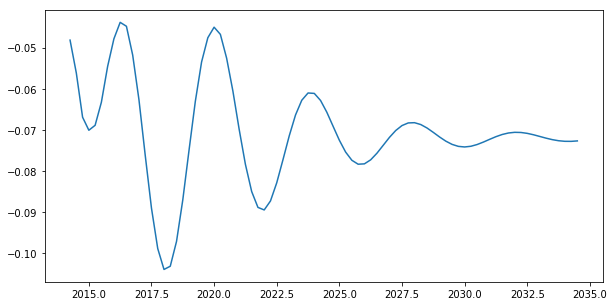

In [63]:
x_test_2 = x_test.iloc[:1]
x_test_2.loc[2014.50] = list(x_test_2.loc[2014.25])[:5] + [0.017511] + list(x_test_2.loc[2014.25])[6:]
pred = [x_test.iloc[:1].values[0][0]]
pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
for i in range(80):
    #Создание новой строчки
    new_line = []
    new_line.append(pred[-1])
    new_line = new_line + list(x_test_2.iloc[-1])[0:4]  +[LinearRegression_model.predict(np.array(list(x_test_2.iloc[-1])[5:7]).reshape(1, -1))[0]] +list(x_test_2.iloc[-1])[5:7]
    #добавление новой строчки
    x_test_2.loc[2014.75+0.25*i] = new_line
    pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
plt.plot(x_test_2.index.values, pred)

In [58]:
x_test_2.head()

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2014.25,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110
2014.50,-0.048167,-0.039545,-0.039611,-0.055057,-0.078589,0.017511,0.016362,0.016110
2014.75,-0.056171,-0.048167,-0.039545,-0.039611,-0.055057,0.015926,0.017511,0.016362
2015.00,-0.066905,-0.056171,-0.048167,-0.039545,-0.039611,0.012123,0.015926,0.017511
2015.25,-0.070067,-0.066905,-0.056171,-0.048167,-0.039545,0.006872,0.012123,0.015926


In [61]:
x_test_2.iloc[-1:]

,unemployment_cyclicity_lag_1,unemployment_cyclicity_lag_2,unemployment_cyclicity_lag_3,unemployment_cyclicity_lag_4,unemployment_cyclicity_lag_5,GDP_cyclicity_lag_1,GDP_cyclicity_lag_2,GDP_cyclicity_lag_3
2042.25,-0.053421,0.069686,0.115764,0.141037,0.16247,-0.321778,-0.457335,-0.538228


# Положительный шок

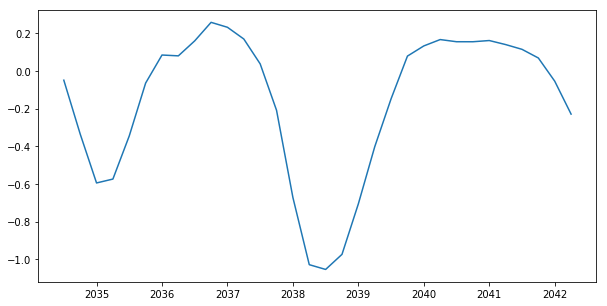

In [60]:
x_test_2 = x_test_2.iloc[-1:]
x_test_2.loc[2034.75] = list(x_test_2.loc[2034.50])[:5] + [-0.001148+1] + list(x_test_2.loc[2034.50])[6:]
pred = [x_test.iloc[:1].values[0][0]]
pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
for i in range(30):
    #Создание новой строчки
    new_line = []
    new_line.append(pred[-1])
    new_line = new_line + list(x_test_2.iloc[-1])[0:4]  +[LinearRegression_model.predict(np.array(list(x_test_2.iloc[-1])[5:7]).reshape(1, -1))[0]] +list(x_test_2.iloc[-1])[5:7]
    #добавление новой строчки
    x_test_2.loc[2035+0.25*i] = new_line
    pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
plt.plot(x_test_2.index.values, pred)

# Отрицательный шок

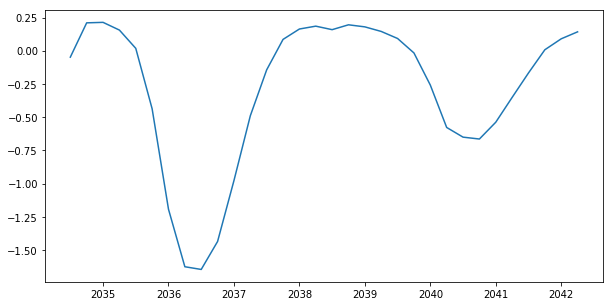

In [64]:
x_test_2 = x_test_2.iloc[-1:]
x_test_2.loc[2034.75] = list(x_test_2.loc[2034.50])[:5] + [-0.001148-1] + list(x_test_2.loc[2034.50])[6:]
pred = [x_test.iloc[:1].values[0][0]]
pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
for i in range(30):
    #Создание новой строчки
    new_line = []
    new_line.append(pred[-1])
    new_line = new_line + list(x_test_2.iloc[-1])[0:4]  +[LinearRegression_model.predict(np.array(list(x_test_2.iloc[-1])[5:7]).reshape(1, -1))[0]] +list(x_test_2.iloc[-1])[5:7]
    #добавление новой строчки
    x_test_2.loc[2035+0.25*i] = new_line
    pred.append(load_model[i_best][j_best].predict(x_test_2)[-1][0])
plt.plot(x_test_2.index.values, pred)